In [1]:
import csv
import pandas as pd
from transformers import pipeline
# Open and read the CSV file using the csv module
csv_file_path = "Nasdaq_stocks.csv"
rows = []

with open(csv_file_path, 'r', encoding='utf-8', errors='ignore') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        rows.append(row)

# Create a DataFrame from the list of rows
stocks = pd.DataFrame(rows[1:], columns=rows[0])

stocks.shape

(6788, 13)

In [2]:
stocks_data = stocks[['Date','Article_title','Stock_symbol']]
# Convert 'date' column to datetime type
stocks_data.loc[:, 'Date'] = pd.to_datetime(stocks_data['Date'], utc=True)

# Filter data for the years 2015 to 2023
start_date = pd.Timestamp('2019-01-01',tz="UTC")
end_date = pd.Timestamp('2023-12-31',tz="UTC")

stocks_data = stocks_data[(stocks_data['Date'] >= start_date) & (stocks_data['Date'] <= end_date)]
stocks_data.loc[:, 'Date'] = stocks_data['Date'].astype('str')
# Extract date component as string 'YYYY-MM-DD' using string manipulation
stocks_data.loc[:, 'Date'] = stocks_data['Date'].str.split().str[0]

In [3]:
stocks_data = stocks_data.rename(columns={'Article_title': 'headlines'})
stocks_data["Stock_symbol"].value_counts()


Stock_symbol
AAPL    6788
Name: count, dtype: int64

In [4]:
from multiprocessing import Pool, cpu_count
df = stocks_data

In [5]:
#!pip install transformers
# Initialize sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Function to process a batch of headlines
def process_batch(batch):
    return [sentiment_pipeline(text)[0]['label'] for text in batch]

# Split the dataframe into batches
batch_size = 100  # Adjust the batch size as needed
batches = [df['headlines'][i:i + batch_size] for i in range(0, len(df), batch_size)]

# Use multiprocessing to process the batches
with Pool(cpu_count()) as pool:
    results = pool.map(process_batch, batches)

print(results)
# Flatten the list of results
df['sentiment'] = [item for sublist in results for item in sublist]

# Convert sentiment labels to numerical scores
sentiment_to_score = {
    'POSITIVE': 1,
    'NEGATIVE': -1,
    'NEUTRAL': 0
}
df['sentiment_score'] = df['sentiment'].map(sentiment_to_score)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that aut

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

In [ ]:
# Calculate average sentiment score for each day
daily_sentiment = df.groupby(['Date','Stock_symbol']).agg({
    'sentiment_score': 'mean'
}).reset_index()

file_path = 'stocks_data_with_sentiment.csv'
daily_sentiment.to_csv(file_path, index=False)

In [ ]:
df["sentiment"].value_counts()

NameError: name 'df' is not defined

In [ ]:
import pandas as pd
df = pd.read_csv("stocks_data_sentiment_score.csv")

In [ ]:
df.head(5)

,Date,Stock_symbol,sentiment_score
0,2019-01-01,INTC,-1.000000
1,2019-01-02,GOOGL,-1.000000
2,2019-01-02,INTC,-0.250000
3,2019-01-02,NVDA,-1.000000
4,2019-01-03,GOOGL,-0.333333


<ipython-input-3-2d076926d4b3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='sentiment_score', y='Stock_symbol', inner='box', palette='Dark2')


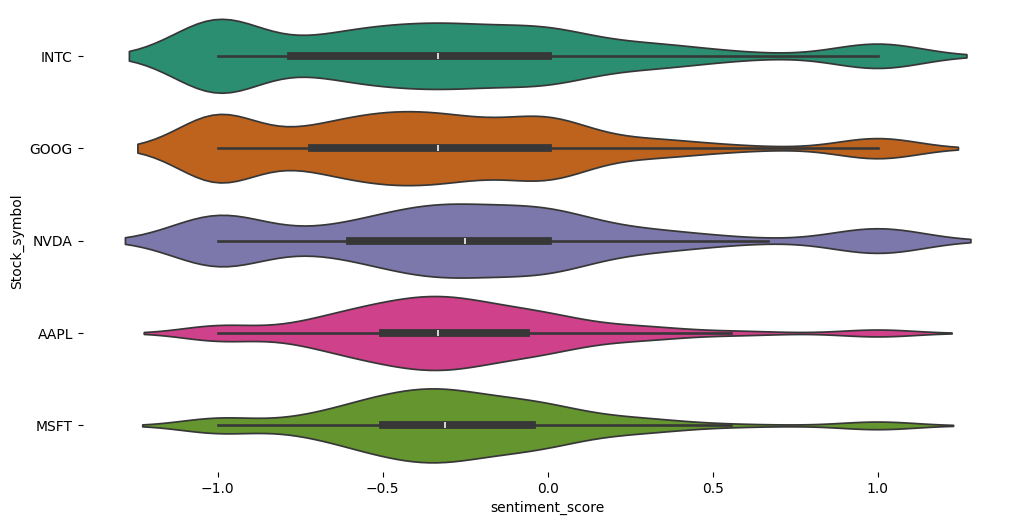

In [ ]:
# @title Stock_symbol vs sentiment_score

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Stock_symbol'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='sentiment_score', y='Stock_symbol', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
def assign_label(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create a new column 'label'
df['label'] = df['sentiment_score'].apply(assign_label)

In [ ]:
df['label'].value_counts()

label
negative    3891
positive    1065
neutral      675
Name: count, dtype: int64

In [ ]:
df.head()

,Date,Stock_symbol,sentiment_score,label
0,2019-01-01,INTC,-1.000000,negative
1,2019-01-02,GOOG,-1.000000,negative
2,2019-01-02,INTC,-0.250000,negative
3,2019-01-02,NVDA,-1.000000,negative
4,2019-01-03,GOOG,-0.333333,negative


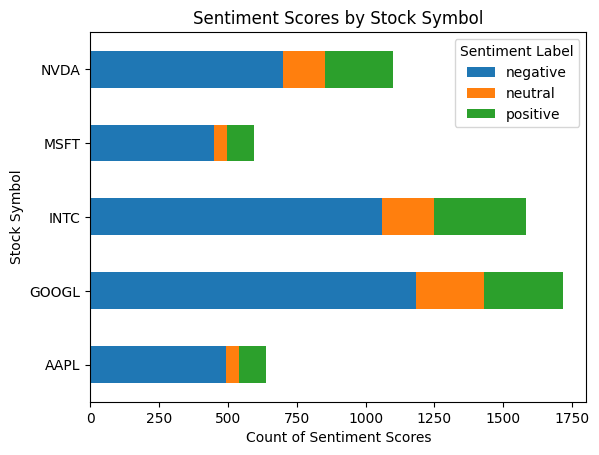

In [ ]:
# Extract the year from the date
import matplotlib.pyplot as plt
import numpy as np
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Pivot the table to get the count of each label per stock symbol
pivot_table = df.pivot_table(index='Stock_symbol', columns='label', aggfunc='size', fill_value=0)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plotting
pivot_table.plot(kind='barh', stacked=True, color=colors)

# Customize the plot
plt.title('Sentiment Scores by Stock Symbol')
plt.xlabel('Count of Sentiment Scores')
plt.ylabel('Stock Symbol')
plt.legend(title='Sentiment Label')

# Display the plot
plt.show()

In [ ]:
# Group by 'Stock_symbol' and count rows based on sentiment_score conditions
count_positive = df[df['sentiment_score'] > 0].groupby('Stock_symbol').size()
count_negative = df[df['sentiment_score'] < 0].groupby('Stock_symbol').size()
count_neutral = df[df['sentiment_score'] == 0].groupby('Stock_symbol').size()

# Fill missing values with 0
count_positive = count_positive.fillna(0)
count_negative = count_negative.fillna(0)
count_neutral = count_neutral.fillna(0)

print("Count of rows where sentiment score is > 0:")
print(count_positive)

print("\nCount of rows where sentiment score is < 0:")
print(count_negative)

print("\nCount of rows where sentiment score is = 0:")
print(count_neutral)


Count of rows where sentiment score is > 0:
Stock_symbol
AAPL    100
GOOG    286
INTC    333
MSFT     97
NVDA    249
dtype: int64

Count of rows where sentiment score is < 0:
Stock_symbol
AAPL     494
GOOG    1185
INTC    1061
MSFT     451
NVDA     700
dtype: int64

Count of rows where sentiment score is = 0:
Stock_symbol
AAPL     45
GOOG    245
INTC    188
MSFT     46
NVDA    151
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report
import plotly.graph_objects as go
from scipy.stats import skew, kurtosis
import yfinance as yf
import logging
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Fetch Data
stocks = ['AAPL', 'GOOGL', 'MSFT', 'INTC', 'NVDA']
start_date = '2019-01-02'
end_date = '2023-12-31'

# Fetch data ensuring only working days
data = yf.download(stocks, start=start_date, end=end_date)
df = pd.read_csv("stocks_data_sentiment_score.csv")
adj_close_data = data['Adj Close'].dropna()

In [ ]:
# Reset index to have dates as a column
adj_close_data = adj_close_data.reset_index()
# Melt the dataframe to have a long format with dates and tickers as rows
melted_data = adj_close_data.melt(id_vars=['Date'], var_name='Ticker', value_name='Adj_Close')

melted_data.rename(columns={"Ticker":"Stock_symbol"},inplace=True)
melted_data['Date'] = melted_data['Date'].astype(str)

In [ ]:
merged_df = pd.merge(melted_data, df, on=['Date', 'Stock_symbol'], how='left')

In [ ]:
merged_df['sentiment_score'] = pd.to_numeric(merged_df['sentiment_score'], errors='coerce')
def calculate_correlations(df):
    # Fill NaN values in sentiment_score with 0
    merged_df['sentiment_score'].fillna(0, inplace=True)

    # Group by Stock_symbol
    grouped = merged_df.groupby('Stock_symbol')

    correlations = {}
    for stock, group in grouped:
        if not group['sentiment_score'].isnull().all() and not group['Adj_Close'].isnull().all():
            correlation = group['Adj_Close'].corr(group['sentiment_score'])
            correlations[stock] = correlation

    return correlations

# Example usage
correlations = calculate_correlations(df)

print("Correlation between Adj_Close and sentiment_score for each stock:")
for stock, correlation in correlations.items():
    print(f"{stock}: {correlation}")

In [ ]:
merged_df = merged_df.dropna()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to create hexbin plots for each stock in a single frame
def plot_hexbin_per_stock(data, cmap='cividis'):
    unique_stocks = data['Stock_symbol'].unique()
    num_stocks = len(unique_stocks)
    fig, axes = plt.subplots(nrows=num_stocks, ncols=1, figsize=(8, 6 * num_stocks))

    for ax, stock in zip(axes, unique_stocks):
        stock_data = data[data['Stock_symbol'] == stock]
        hb = ax.hexbin(x=stock_data['sentiment_score'], y=stock_data['Adj_Close'], gridsize=30, cmap=cmap, mincnt=1)
        cb = fig.colorbar(hb, ax=ax, label='Count')
        ax.set_title(f'Hexbin Plot: Sentiment Score vs Adj_Close Price for {stock}')
        ax.set_xlabel('Sentiment Score')
        ax.set_ylabel('Adjusted Close Price')

    plt.tight_layout()
    plt.show()

# Call the function with the dataframe and a selected colormap
plot_hexbin_per_stock(merged_df, cmap='cividis')
